In [1]:
from Hugos_tools.Approximation import (Approximation, Mask_dir_peak_valley,
                                          Except_dir, Mask_status_peak_valley,
                                          Relative_values)

from Hugos_tools.performance import Strategy_performance
from collections import (defaultdict, namedtuple)
from typing import (List, Tuple, Dict, Union, Callable, Any)

import datetime as dt
import empyrical as ep
import numpy as np
import pandas as pd
import talib
import scipy.stats as st
from IPython.display import display

from sklearn.pipeline import Pipeline

from jqdatasdk import (auth, get_price, get_trade_days)

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.
auth success 


相关依赖

|库|版本号|
|--|--|
|pandas|1.2.4|
|eaborn|0.11.1|
|matplotlib|3.3.4|
|scikit-learn|0.24.1|
|numpy|1.20.1|
|scipy|1.6.2|

# 自动化波段划分模型算法介绍

1. 模型基于一个成熟且完备的技术分析体系

    选择一个成熟的技术分析体系作为基础能够避免在波段划分中过多地引入主 观想法，更加客观地从价格走势出发进行分析与判断。同时，以成熟的体系为基
础也能够为当下走势的判断提供重要依据，将不确定性降低。

2. 在每个波段中，价格的最高点和最低点一定是在波段的端点
    技术分析在使用中并不能实时地准确判断出价格最高点或最低点。因此，直 接使用技术面分析体系划分出的波段后，波段内的最高/最低点可能不在波段的起 始或结束点（端点）上。然而，最高/最低点却是―低买高卖‖的关键。以最高和最
低点为端点的波段能够更加精准地划分价格走势，并提供最为直接的信息以提高 ―低买高卖‖带来的收益。因此，我们要求划分出的波段中，端点是波段内的最高/
最低点。

3. 模型能识别大的趋势，同时能抓住小的行情
    怎样幅度的价格波动才能成为波段，也是波段划分的重点难题。如果只标注 出了大趋势中明确的最高/最低点，就可能错过相对较小的趋势，从而错失了短期 的波动。因此，一个好的波段划分模型需要自适应价格序列的走势，识别出大而 明显的行情变化，同时也能抓住小的行情。 整体而言，我们的波段划分模型主要分为两个部分：基于改进后的MACD指标进行的上下行划分，以及对于异常端点的自动化修正。通过使用MACD指标中 的 DIF 和 DEA 线并加以优化改进后，指标划分出的上下行能够将高点和低点所 在的区间标注出来，这是我们模型后续高低点标注以及波段划分的基础；而针对 异常端点的自动化修正算法则是为了确保上述的三个要求。因此，我们对于波段 的划分分为三个步骤：通过改进后的 MACD 指标得到价格上下行、由上下行判断并修正得到高低点、最后将高低点连接形成波段。

In [3]:
# 画图

def plot_pivots(peak_valley_df: pd.DataFrame,
                show_dir: Union[str,List,Tuple]='dir',
                show_hl: bool = True,
                show_point:bool = True,
                title: str = '',
                ax=None):

    if ax is None:

        fig, ax = plt.subplots(figsize=(18, 6))

        line = peak_valley_df.plot(y='close', alpha=0.6, title=title, ax=ax)

    else:

        line = peak_valley_df.plot(y='close', alpha=0.6, title=title, ax=ax)

    if show_hl:

        peak_valley_df.plot(ax=line,
                            y='PEAK',
                            marker='o',
                            color='r',
                            mec='black')

        peak_valley_df.plot(ax=line,
                            y='VALLEY',
                            marker='o',
                            color='g',
                            mec='black')
    
    if show_point:
        
        peak_valley_df.dropna(subset=['POINT']).plot(ax=line,
                                                     y='POINT',
                                                     color='darkgray',
                                                     ls='--')
    if show_dir:

        peak_valley_df.plot(ax=line,
                            y=show_dir,
                            secondary_y=True,
                            alpha=0.3,
                            ls='--')

    return line

In [4]:
def get_clf_wave(price: pd.DataFrame,
                 rate: float,
                 method: str,
                 except_dir: bool = True,
                 show_tmp: bool = False,
                 dropna: bool = True) -> pd.DataFrame:
    
    
    if except_dir:
        
        # 修正
        perpare_data = Pipeline([('approximation', Approximation(rate, method)),
                ('mask_dir_peak_valley',Mask_status_peak_valley('dir')),
                ('except', Except_dir('dir')),
                ('mask_status_peak_valley', Mask_dir_peak_valley('status'))
                ])
    else:
        
       # 普通
        perpare_data = Pipeline([('approximation', Approximation(rate, method)),
                ('mask_dir_peak_valley',Mask_dir_peak_valley('dir')),
                ('mask_status_peak_valley', Mask_status_peak_valley('dir'))])
        
   

    return perpare_data.fit_transform(price)

In [27]:
hs300 = get_price('000300.XSHG',
                  '2005-04-08',
                  '2021-10-22',
                  fields=['close', 'high', 'low', 'open'],
                  panel=False)

hs300.to_csv('hs300.csv')

In [8]:
hs300 = pd.read_csv('hs300.csv',index_col=[0],parse_dates=[0])

## 针对MACD价格划分方式的改进

In [6]:
# 方式1:划分上下行

flag_frame1: pd.DataFrame = get_clf_wave(hs300,None,'a',False)

begin, end = '2020-02-01','2020-07-20'

flag_df1 = flag_frame1.loc[begin:end,['close','dir']]

flag_df1 = flag_df1.rename(columns={'dir':'方式1划分上下行'})

在波段划分之前，我们首先需要知道价格走势的大致变化，即价 格的上下行。上下行并不是最终的波段结果，只是基础。我们希望上行区间内包 括了所有最终的高点，下行区间内包括了所有的低点，即上/下行的时间窗口为最 高/最低点的潜在区域。因此，我们需要通过 MACD 指标将一段时间窗口内的相 对高点划分至上行中，相对低点划分至下行中。为了达到这一目的，我们要求上下行在价格确认反转后变换，这样高低点就能被划分至对应的区域中。

下图红线为2021年1月4日至2021年7月30日沪深300指数的收盘价（左侧纵轴），蓝线和灰线则分别代表对应时间的DIF线与DEA线（右侧纵 轴）。可以明显看出，当DIF大于DEA时，价格处于上行趋势，反之则处于下行 趋势。由此认为，DIF 和 DEA 相结合的使用方式对价格的上下行具有划分能力，这符合我们对于上下行的要求。

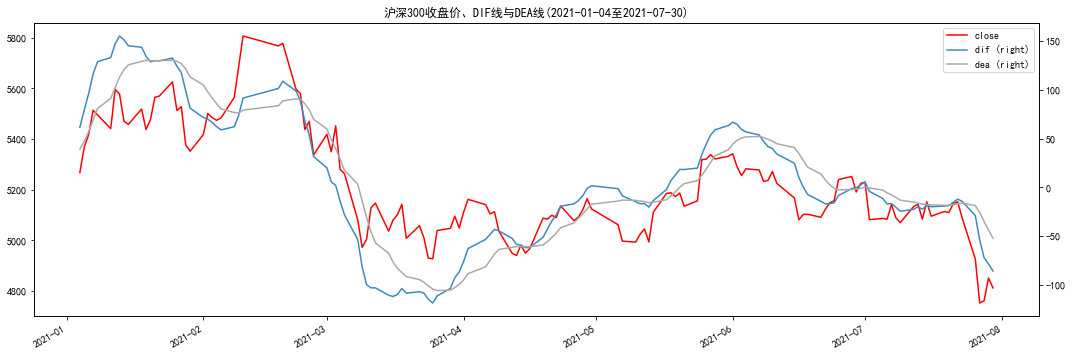

In [7]:
line = flag_frame1.loc['2021-01-01':'2021-07-30'].plot(figsize=(18, 6), y='close', color='red',
                    title='沪深300收盘价、DIF线与DEA线(2021-01-04至2021-07-30)')

flag_frame1.loc['2021-01-01':'2021-07-30'].plot(ax=line, y=['dif', 'dea'],
             secondary_y=True, color=['#3D89BE', 'darkgray']);

## 划分方式1 

我们定义𝐷𝐼𝐹[𝑡]和𝐷𝐸𝐴[𝑡]分别代表𝑡时刻的DIF值和 DEA 值，同时我们定义上行区域为𝐷𝑖𝑟 = 1，下行区域为𝐷𝑖𝑟 = −1。由此，一 个简单且直观的上下行划分方式：

t时刻上下行方向$Dir[t] = \begin{cases}1,如果DIF[t]-DEA[t] \ge 0 \\-1, DIF[t]-DEA[t] \lt 0\end{cases}$

这种上下行的构建方式与 MACD 指标中的金叉、死叉类似，相对简单直观。 然而，在实际使用中也很容易发现，DIF与DEA线经常存在上下反复穿越的情况，尤其是在震荡行情和价格拐点上。

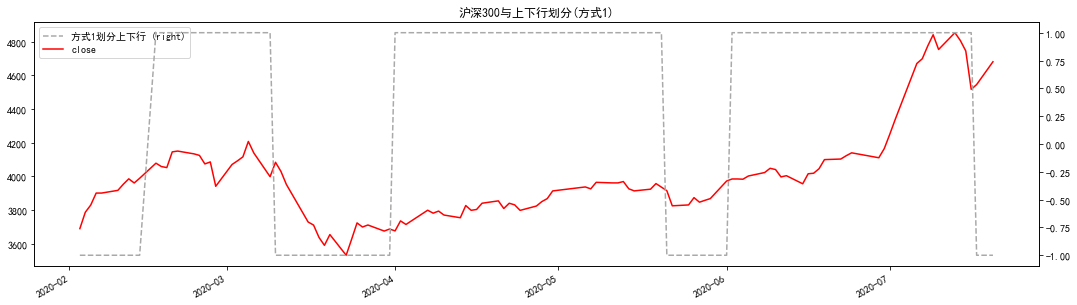

In [6]:
# 画图
line = flag_df1.plot(y='方式1划分上下行', secondary_y=True, figsize=(
    18, 5), ls='--', color='darkgray', title='沪深300与上下行划分(方式1)')

flag_df1.plot(y='close', ax=line, color='r');

## 划分方式二

**划分方式一**这种上下行的构建方式与 MACD 指标中的金叉、死叉类似，相对简单直观。 然而，在实际使用中也很容易发现，DIF与DEA线经常存在上下反复穿越的情况，尤其是在震荡行情和价格拐点上。在出现震荡时均线缠绕导致上下行方向出现频率过高地转变，进而影响后续的高低点判断，实操性非常差故对其改进:

$t时刻上下行方向Dir[t]=\begin{cases}1,如果DIF[t] - DEA[t] \ge \delta \\ -1,如果DIF[t] - DEA[t] \lt \delta \end{cases}$

其中$\delta_t=Rate_\delta \times ATR[t] $

相比于方式1，方式2中引入一个阈值$\delta$。只有当𝐷𝐼𝐹[𝑡]与𝐷𝐸𝐴[𝑡]的差异足够大，即大于阈值时，我们才会认为上行状态出现，反之亦然。通过设置阈值的方式，我们解决了方式1中上下行切换过于频繁的问题，同时提高了上下行的划分质量。在实际使用中，阈值可以设定为一个固定值$\delta$，或者是一个基于价格的技术指标$\delta_t$。我们认为技术指标$\delta_t$的设定需要自适应的结合时点走势加以确认。因此,引入ATR指标。

In [7]:
# 方式2:划分上下行
flag_frame2: pd.DataFrame = get_clf_wave(hs300,0.5,'b',False)

flag_df2 = flag_frame2.loc[begin:end,['close','dir']]

flag_df2 = flag_df2.rename(columns={'dir':'方式2划分上下行'})

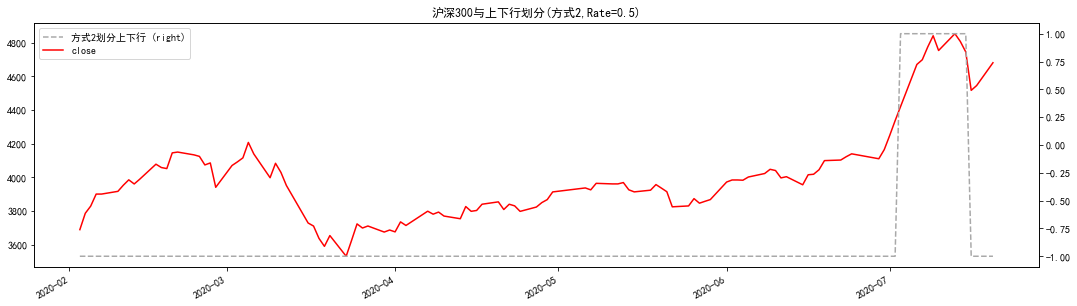

In [8]:
# 画图
line = flag_df2.plot(y='方式2划分上下行', secondary_y=True, figsize=(
    18, 5), ls='--', color='darkgray', title='沪深300与上下行划分(方式2,Rate=0.5)')

flag_df2.plot(y='close', ax=line, color='r');

## 划分方式三

在解决了切换过于频繁的问题后，**方式2**已经相对完善。然而，深入研究后 发现，在某些情况下，当DIF穿越DEA线后，差值可能始终较小，抑或者，DIF在DEA线附近小幅度穿越。引入一种同号差异累计值Intergral[t]解决**缓慢上涨和下跌**无法识别的问题。由于这里有累计值,所以我个人认为这里应该是有一个累计的“窗口”的隐藏参数存在，而原报告并未提及仅认为模型只有一个参数$Rate_{\delta}$。我个人认为这个可能是个风险。故我在累计中加入了滚动计算窗口期为12。

$𝑡时刻同号差异值累计值Integral[t]=\begin{cases}1,如果𝐷𝐼𝐹[𝑡] = 𝐷𝐸𝐴[𝑡] \\ -1,如果\sum^{n}_{n=t-k}(𝐷𝐼𝐹[n] - 𝐷𝐸𝐴[n]) \end{cases}$

其中在n = [t − k, t]这一时间段中，差异值DIF[n] − DEA[n]需要为同号(同正或同负)。通过这一数值，我们就能考虑到差异值与时间的协同关系。只有在一段时间内，DIF 线相对于 DEA 线的累计距离足够大时,上下行才开始切换。

$𝑡时刻上下行方向𝐷𝑖𝑟[𝑡] = \begin{cases}1,Integral[t] \ge - \delta \\-1,Integral[t] \lt \delta \end{cases}$

In [9]:
# 方式3:划分上下行

flag_frame3: pd.DataFrame = get_clf_wave(hs300,2,'c',False)

flag_df3 = flag_frame3.loc[begin:end,['close','dir']]

flag_df3 = flag_df3.rename(columns={'dir':'方式3划分上下行'})

我们以2020年2月5日以来的沪深300走势进行简单的实证分析，下图。 可以看到，基于方式3的上下行划分方式大致地将区间内的价格走势划分为两段上行与两段下行区域。在确认下跌后，方向由上行转为下行，将高点留在了上行区域中。因此，上行区域中的点位均高于下行区域。在实际标注高低点时，这一 时间段中的高点显然不可能出现在下行区域内，反之亦然。因此，方法3得到的上下行能够划分出最高点和最低点的潜在区域。

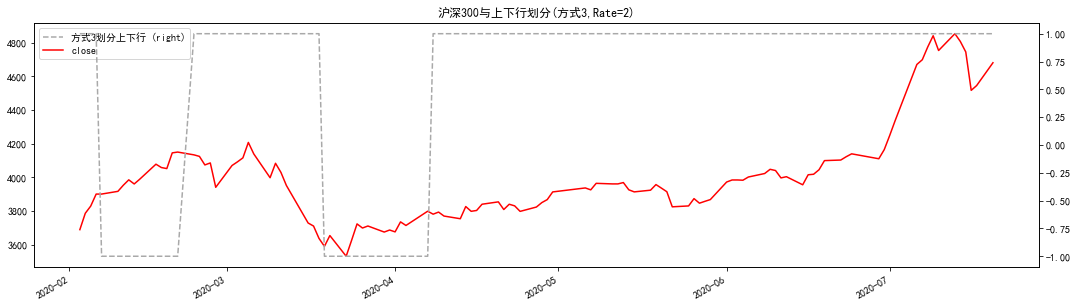

In [10]:
# 画图
line = flag_df3.plot(y='方式3划分上下行', secondary_y=True, figsize=(
    18, 5), ls='--', color='darkgray', title='沪深300与上下行划分(方式3,Rate=2)')

flag_df3.plot(y='close', ax=line, color='r');

## 高低点识别与异常端点

完成了上下行的划分后，我们已经得到了基于改进后的MACD体系划分出的 价格的大致趋势，即上下行区间的确认。这也间接满足了我们模型的第一个要求。 在此基础上，我们关注高低点的识别问题。 先前提到过，高低点一定是波段的端点。由此，我们在整个时间段中，高低
点一定是相互间隔排列的：


$t[H_1]<t[H_2]<\dots;$

$t[L_1]<t[L_2]<\dots;$

若第一个端点为高点则排列方式为:$t[H_1]<t[L_1]<t[H_1]<t[L_1]<\dots$


因此，我们在上行中寻找区间内 的极大点，同时在上行结束时确定上行区间内的极大点为一个高点，反之亦然。

然而，若将现在的高低点直接连接作为波段，将造成一个问题 – **部分波段的最高/最低点并不在波段的端点。**

### 异常端点的自动化修正

我们加入一个异常状态变量，即当下行中价格破高，或上行中价格破低时，异常状态出现，需要进行修正。我们 定义时间𝑡的异常状态变量为𝐸𝑥𝑐𝑒𝑝𝑡[𝑡]。其中𝐸𝑥𝑐𝑒𝑝𝑡[𝑡] = 1代表 t 时刻无异常， 𝐸𝑥𝑐𝑒𝑝𝑡[𝑡] = −1代表 t 时刻有异常。若前一时刻不存在异常状态（𝐸𝑥𝑐𝑒𝑝𝑡[𝑡 − 1] = 1），且上下行方向未在𝑡时刻转变时，我们需要判断是否出现异常状态，即是否在上行中俯冲破前一个低点或在下行中拉升破前一个高点：

$Except[t] = \begin{cases} -1,如果(Dir[t]=1且收盘价[t] \leq 前一个低点)或(Dir[t]=-1且收盘价[t] \geq 前一个高点) \\ 1,如果不出现上述情况\end{cases}$

若前一时刻存在异常状态（𝐸𝑥𝑐𝑒𝑝𝑡[𝑡 − 1] = −1），我们需要判断价格走在了 上下行之前，抑或是上下行中一个力度较强的回调：

$Except[t] = \begin{cases} -1,如果不出现下述情况 \\ 1,如果(Dir[t-1] \neq Dir[t])或(Dir[t-1] = 1且收盘价[t]\geq 前一个高点)或(Dir[t-1] = -1且收盘价[t]\leq前一个低点) \end{cases}$

也就说，当𝑡 − 1时刻存在异常状态：如果上下行在𝑡时刻转变，可以说是价格先于上下行反应，可以退出异常状态；如果上下行在𝑡时刻未转变，但若上行状态下价格破了新高，则认为本次回调结束，退出异常状态，反之亦然。不难看出，这样的程序化设定通过参考前一时刻异常状态以及当前是否破高/低的方式，将上述两类出现异常（破高/低）和两类结束异常（价在方向前/力度较强的回调）的情 况都考虑了进去。通过这种简洁明了的逻辑和算法，我们的异常端点修正方式避免了人工客观地判断，完全实现自动化修正。

优化改进得到了实时上下行方向序列𝐷𝑖𝑟用于判断价格的大致趋势，又通过异常端点修正得 到了实时异常状态序列𝐸𝑥𝑐𝑒𝑝𝑡。由此，我们进入模型的最后一步，即通过将𝐷𝑖𝑟和𝐸𝑥𝑐𝑒𝑝𝑡结合，得到最终的实时高低点划分模型，并最终划分出波段。
当出现异常状态时，如上行破低时，我们认为当前市场其实应该在一段下跌 中，需要寻找下跌的区间极小值，直到异常状态结束，恢复当前的𝐷𝑖𝑟方向。因此，我们定义一个 t 时刻寻找端点的指标𝑆𝑡𝑎𝑡𝑢𝑠[𝑡]：

$Status[t]=Dir[t] * Except[t]$
若𝑆𝑡𝑎𝑡𝑢𝑠 = 1时存在两种情况：上行且没有异常状态、或者下行并出现异常 状态。在这两种情况中，价格均被判定为处于上涨趋势中，我们需要在前一个低 点至当前时间点的区间内寻找收盘价的极大值。反之，若𝑆𝑡𝑎𝑡𝑢𝑠 = −1时有两种情 况：下行且没有异常状态、或者上行并出现异常状态。同样地，在这两种情况下， 价格被判断为处于下跌趋势，我们应当在前一个高点至当前时间点的区间内寻找 收盘价的极小值。在𝑆𝑡𝑎𝑡𝑢𝑠发生转变时，价格走势发生转向，我们便可以记录先前的区间极大/极小值为高/低点。


In [9]:
# 方式3:划分上下行-修正与普通的划分方式对比

status_frame: pd.DataFrame = get_clf_wave(hs300, 2, 'c', True)
dir_frame: pd.DataFrame = get_clf_wave(hs300, 2, 'c', False)

 从这个截面可以看到修正好部分位置更加准确了，不过感觉也更“过拟”了

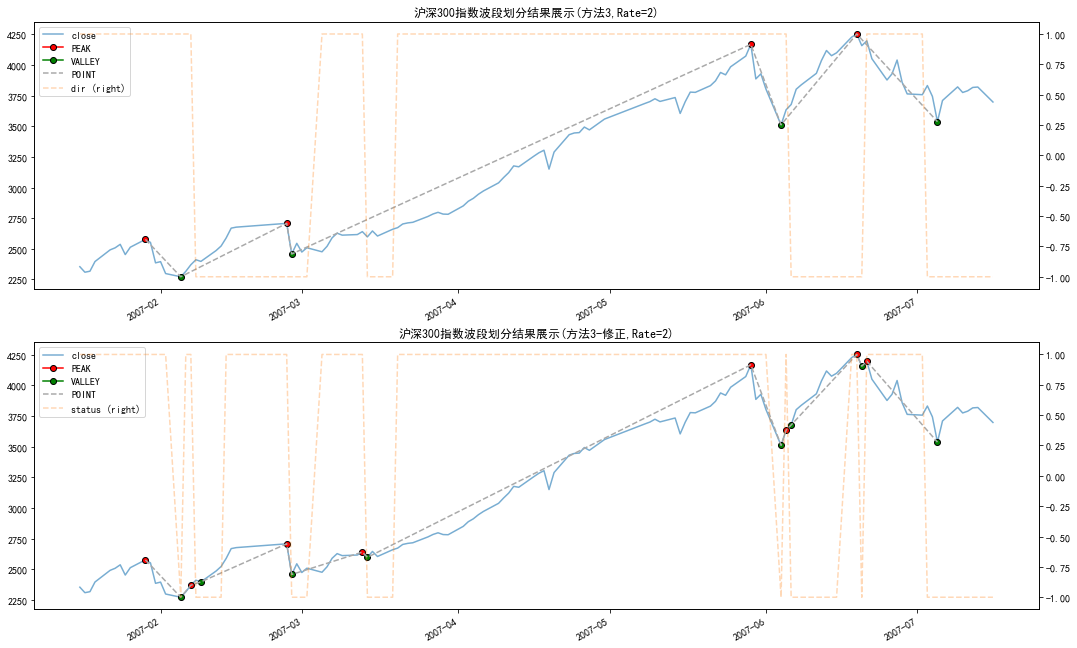

In [9]:
fig, axes = plt.subplots(2,figsize=(18,12))
# 画图
plot_pivots(dir_frame.iloc[330:450],
            show_dir=['dir'],
            show_hl=True,
            title='沪深300指数波段划分结果展示(方法3,Rate=2)',ax=axes[0])

plot_pivots(status_frame.iloc[330:450],
            show_dir=['status'],
            show_hl=True,
            title='沪深300指数波段划分结果展示(方法3-修正,Rate=2)',ax=axes[1]);

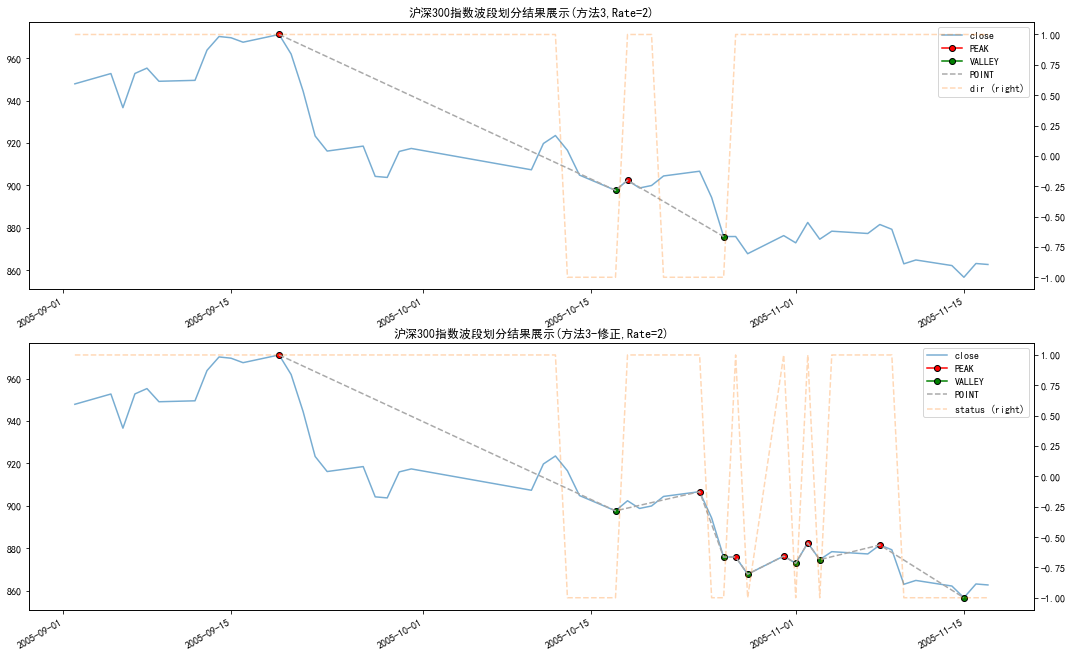

In [10]:
fig, axes = plt.subplots(2,figsize=(18,12))
# 画图
plot_pivots(dir_frame.iloc[:50],
            show_dir=['dir'],
            show_hl=True,
            title='沪深300指数波段划分结果展示(方法3,Rate=2)',ax=axes[0])

plot_pivots(status_frame.iloc[:50],
            show_dir=['status'],
            show_hl=True,
            title='沪深300指数波段划分结果展示(方法3-修正,Rate=2)',ax=axes[1]);

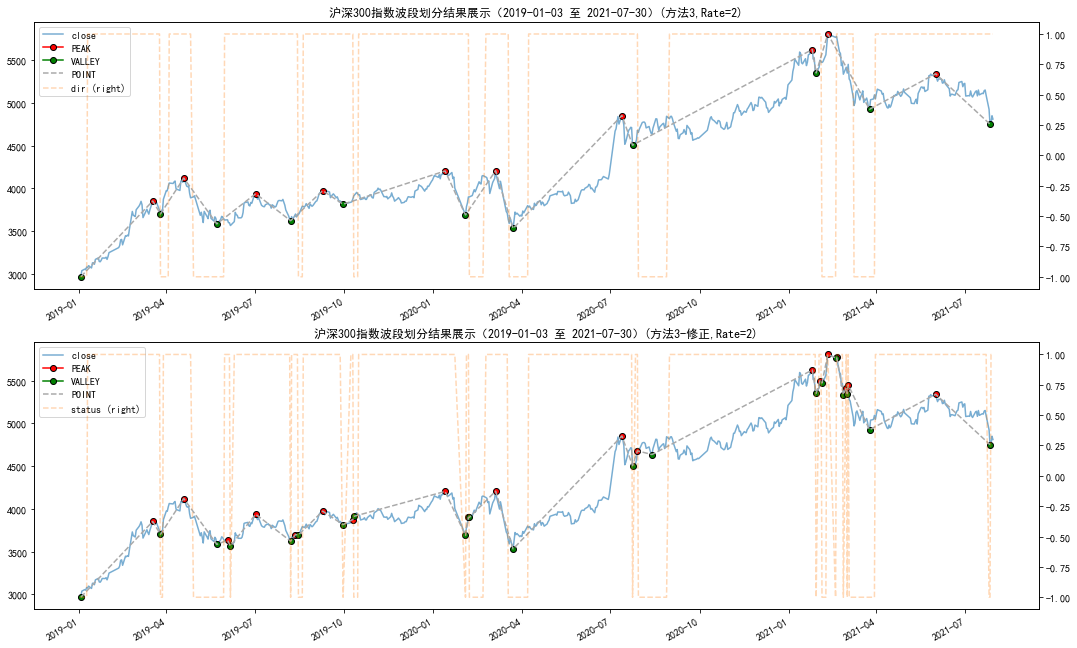

In [11]:
fig, axes = plt.subplots(2,figsize=(18,12))
# 画图
plot_pivots(dir_frame.loc['2019-01-01':'2021-07-30'],
            show_dir=['dir'],
            show_hl=True,
            title='沪深300指数波段划分结果展示（2019-01-03 至 2021-07-30）(方法3,Rate=2)',ax=axes[0])

plot_pivots(status_frame.loc['2019-01-01':'2021-07-30'],
            show_dir=['status'],
            show_hl=True,
            title='沪深300指数波段划分结果展示（2019-01-03 至 2021-07-30）(方法3-修正,Rate=2)',ax=axes[1]);

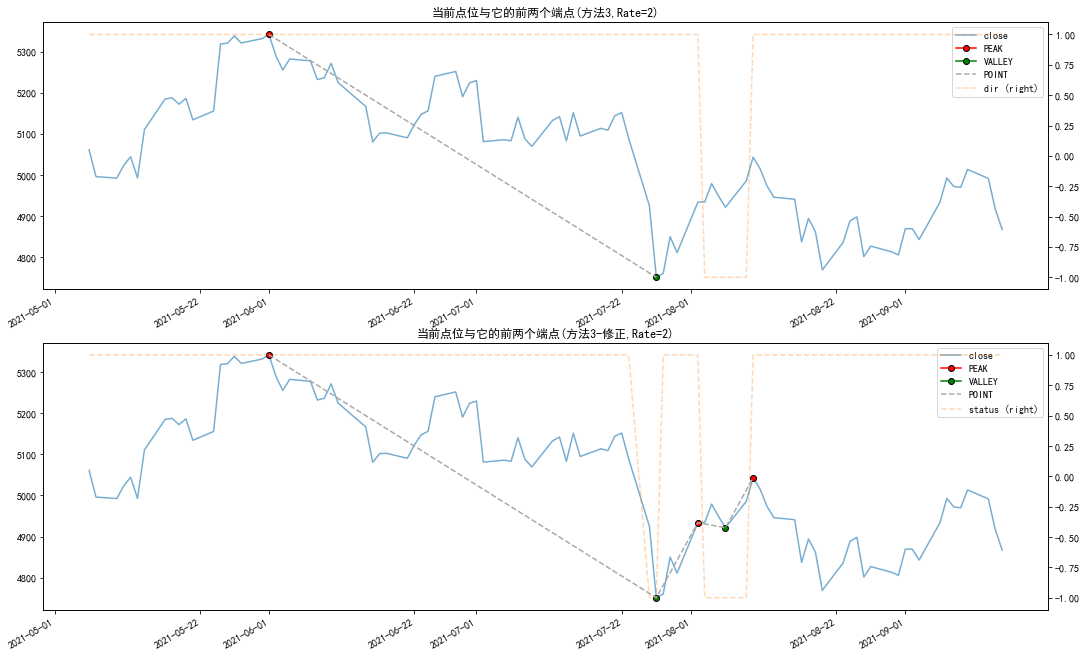

In [12]:
fig, axes = plt.subplots(2,figsize=(18,12))
# 画图
plot_pivots(dir_frame.loc['2021-05-01':'2021-09-15'],
            show_dir=['dir'],
            show_hl=True,
            title='当前点位与它的前两个端点(方法3,Rate=2)',ax=axes[0])

plot_pivots(status_frame.loc['2021-05-01':'2021-09-15'],
            show_dir=['status'],
            show_hl=True,
            title='当前点位与它的前两个端点(方法3-修正,Rate=2)',ax=axes[1]);

# 上下行划分分析

<AxesSubplot:title={'center':'沪深300指数波段划分结果展示(方法3,Rate=2)'}>

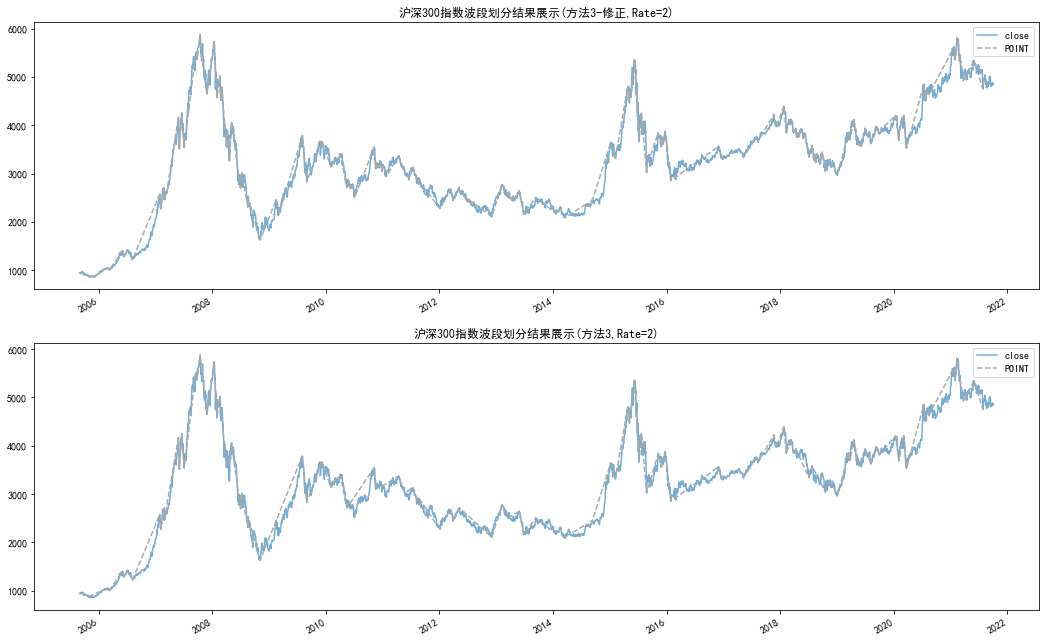

In [12]:
fig, axes = plt.subplots(2,figsize=(18,12))

plot_pivots(status_frame,
            show_dir=False,
            show_hl=False,
            title='沪深300指数波段划分结果展示(方法3-修正,Rate=2)',ax=axes[0])

plot_pivots(dir_frame,
            show_dir=False,
            show_hl=False,
            title='沪深300指数波段划分结果展示(方法3,Rate=2)',ax=axes[1])

基于日度沪深300指数的波段划分结上图 。纵观整个时间区间，无论是大趋势还是长期震荡，波段的划分几乎与价格走势重合，这也是我们所期望的结果。在考察范围内的3890个(2005-09-02至2021-08-31)交易日中：

**修正方案下**

共有216个波段，其中108个上涨波段，108个下降波段

**普通方案下**

共有113个波段,其中57个上涨波段，56个下降波段

In [5]:
class Segment_stats():
    '''
    分析上下行划分的统计数据
    '''
    def __init__(self,
                 frame: pd.DataFrame,
                 flag_col: str,
                 drop: bool = True) -> None:

        self.data = frame
        self.flag_col = flag_col
        self.drop = drop
        self._COL_NAME_MAP = {-1: '下跌波段', 1: '上涨波段'}
        self._prepare()

    def winsorize_std(self) -> pd.DataFrame:
        ''''标准差去极值'''

        ret = self.stats_frame.groupby('g')['log_ret'].sum()
        up = ret.mean() + ret.std() * 2
        low =  ret.mean() - ret.std() * 2

        group_id = ret[(ret <= up) & (ret >= low)].index.tolist()
        return self.stats_frame.query('g == @group_id')

    def _prepare(self) -> None:
        '''预处理'''
        stats_df = self.data[['close', self.flag_col]].copy()

        stats_df['log_ret'] = np.log(stats_df['close'] /
                                     stats_df['close'].shift(1))

        if self.drop:
            stats_df = stats_df.dropna(subset=[self.flag_col])

        stats_df['g'] = (stats_df[self.flag_col] !=
                         stats_df[self.flag_col].shift(1)).cumsum()

        self.stats_frame = stats_df

    def stats_summary(self, winsorize: bool = False) -> pd.DataFrame:
        '''简易统计报告'''

        if winsorize:

            stats_frame = self.winsorize_std()

        else:

            stats_frame = self.stats_frame

        SUMMARY_STATS = [
            ('均值', lambda x: x.mean()), ('标准差', lambda x: x.std()),
            ('最大值', lambda x: x.max()), ('最小值', lambda x: x.min()),
            ('样本数量', lambda x: len(x))
        ]

        group_stats = stats_frame.groupby([self.flag_col,
                                           'g'])['log_ret'].sum()

        stats = group_stats.groupby(level=self.flag_col).agg(SUMMARY_STATS)

        stats.index = stats.index.map(self._COL_NAME_MAP)

        return display(
            stats.style.format('{:.2%}', subset=['均值', '标准差', '最大值', '最小值']))

    def ttest_segment(self, winsorize: bool = False) -> pd.DataFrame:
        '''波段的T检验'''

        if winsorize:

            stats_frame = self.winsorize_std()

        else:

            stats_frame = self.stats_frame

        t_test = stats_frame.groupby(
            self.flag_col)['log_ret'].apply(lambda x: pd.Series(
                st.ttest_1samp(x.dropna(), 0), index=['statistic', 'pvalue']))

        t_test = t_test.unstack()
        t_test.index = t_test.index.map(self._COL_NAME_MAP)

        return display(
            t_test.style.format({
                'statistic': '{:.2f}',
                'pvalue': '{:.4f}'
            }))

    def plot_segment_ret_hist(self, winsorize: bool = False, **kw):

        if winsorize:

            stats_frame = self.winsorize_std()

        else:

            stats_frame = self.stats_frame

        group_ret = stats_frame.groupby([self.flag_col, 'g'])['log_ret'].sum()

        ret_min = group_ret.min()
        ret_max = group_ret.max()
        
        labels = ['<=5%', '6%-10%', '11%-15%', '16%-20%', '>20%']
        bins = [ret_min, 0.05, 0.1, 0.15, 0.2, ret_max]
        
        if ret_max <= 0.2:
            bins = bins[:-1]
            labels = labels[:-1]
            labels[-1] = '16%-{:.0%}'.format(ret_max)
            
        if ret_min >= 0.05:
            bins = bins[1:]
            labels = labels[1:]
            labels[0] = '6%-{:.0%}'.format(ret_min)
            
        ser: pd.Series = pd.cut(
            group_ret,
            bins=bins,
            labels=labels)

        df = ser.groupby(self.flag_col).value_counts().unstack(level=0)
        df.rename(columns=self._COL_NAME_MAP, inplace=True)

        return df.plot.bar(**kw)

## 修正后波段划分情况

从分布频率来看,波段更多的分布在<=5%的的位置（无论是修正还是普通），这点明显与研报结论相悖

未去极值波段划分情况


,均值,标准差,最大值,最小值,样本数量
status,,,,,
下跌波段,-3.24%,6.88%,12.03%,-38.48%,117.000000
上涨波段,4.59%,10.18%,58.11%,-11.20%,118.000000


,statistic,pvalue
status,,
下跌波段,-5.66,0.0000
上涨波段,6.67,0.0000


去极值波段划分情况


,均值,标准差,最大值,最小值,样本数量
status,,,,,
下跌波段,-2.01%,4.24%,12.03%,-16.21%,111.000000
上涨波段,2.15%,4.97%,19.54%,-11.20%,109.000000


,statistic,pvalue
status,,
下跌波段,-4.04,0.0001
上涨波段,3.58,0.0003


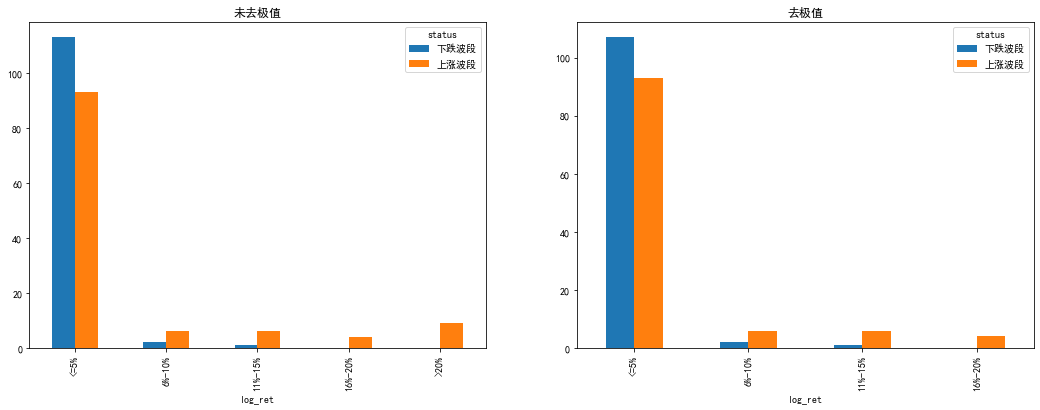

In [14]:
stats_summary = Segment_stats(status_frame,'status')

print('未去极值波段划分情况')
stats_summary.stats_summary()

stats_summary.ttest_segment()


print('去极值波段划分情况')
stats_summary.stats_summary(True)

stats_summary.ttest_segment(True)

fig,axes = plt.subplots(1,2,figsize=(18,6))

stats_summary.plot_segment_ret_hist(title='未去极值',ax=axes[0])
stats_summary.plot_segment_ret_hist(winsorize=True,title='去极值',ax=axes[1]);

## 未修正的波段划分情况

未去极值波段划分情况


,均值,标准差,最大值,最小值,样本数量
dir,,,,,
下跌波段,-0.14%,5.55%,13.44%,-17.21%,56.000000
上涨波段,3.01%,16.06%,61.18%,-22.62%,57.000000


,statistic,pvalue
dir,,
下跌波段,-0.15,0.8787
上涨波段,1.85,0.0647


去极值波段划分情况


,均值,标准差,最大值,最小值,样本数量
dir,,,,,
下跌波段,-0.14%,5.55%,13.44%,-17.21%,56.000000
上涨波段,-1.08%,10.61%,23.27%,-22.62%,51.000000


,statistic,pvalue
dir,,
下跌波段,-0.15,0.8787
上涨波段,-0.66,0.5103


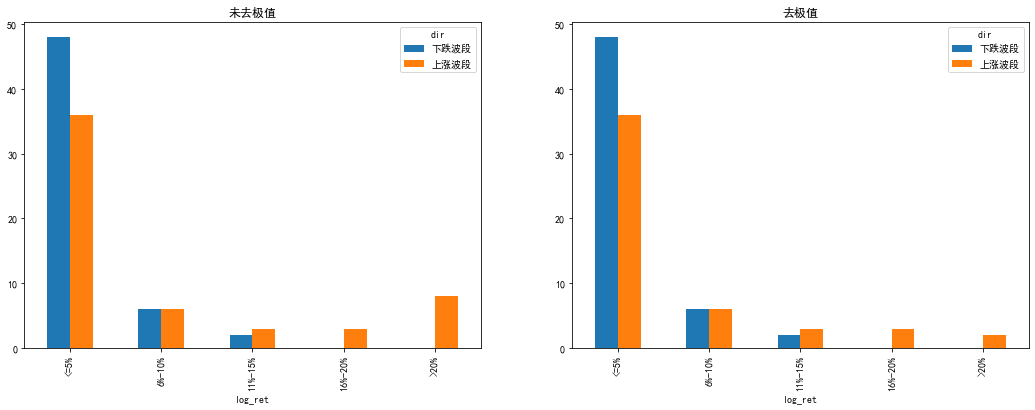

In [15]:
stats_summary = Segment_stats(dir_frame,'dir')

print('未去极值波段划分情况')
stats_summary.stats_summary()

stats_summary.ttest_segment()


print('去极值波段划分情况')
stats_summary.stats_summary(True)

stats_summary.ttest_segment(True)

fig,axes = plt.subplots(1,2,figsize=(18,6))

stats_summary.plot_segment_ret_hist(title='未去极值',ax=axes[0])
stats_summary.plot_segment_ret_hist(winsorize=True,title='去极值',ax=axes[1]);

# 点位效率的理论介绍与计算

对于点位的分析与判断，首先需要解决的问题是该点位在最近一段时间内处 于什么位置。在股市中，标的价格点位依赖于它的时空位置（当前点位涨跌幅度、 时间效率）。例如，同样是沪深 300 指数，2011 年 11 月的 3000 点和 2012 年 1 月 的 3000 点显然具有不同的意义；又例如，假设一种走势中，价格下跌 5%后上涨 5%，另一种走势中价格下跌 20%后上涨 5%。虽然这两种走势在后半段均上涨了 5%，但由于之前时间段的下跌幅度不同，因此上涨阶段包含的信息也不尽相同。 所以说，对价格序列中的点和波段进行分析时，一定不能忽略它之前一段时间内 的价格走势。因此，只有构建出一种立体（点位高低、时间效率）的点位距离衡 量方式，才能从历史走势中获取信息，进而对高低点，未来走势进行判断。 一般来讲，点位和它之前的波段存在着强关联。由此出发，我们构建一种点
的相对距离，称之为点位效率指标。该指标基于我们的波段划分结果，利用当前 点、它的前两个端点以及它们之间的时空数据，来刻画一个点的状态。在这套模式中，我们站在一个时间节点上，已知的信息有：

1. 在时间顺序上，三个点的顺序一定是𝐻 − 𝐿 − 𝑃或者𝐿 − 𝐻 − 𝑃两种；
2. 当前点𝑃的时间点及它的收盘价数据、它的前两个端点：高点𝐻和低点𝐿， 以及它们相应的时间点和收盘价。

我们希望基于这些信息，刻画点𝑃相对于前一个波段处于什么位置。我们首 先定义时间效率𝑟𝑒𝑙𝑎𝑡𝑖𝑣𝑒𝑇𝑖𝑚𝑒和价格效率𝑟𝑒𝑙𝑎𝑡𝑖𝑣𝑒𝑃𝑟𝑖𝑐𝑒，以―高点-低点-当前点‖
的“𝐻 − 𝐿 − 𝑃”顺序为例，我们定义：

时间效率 $relative_time = \frac{Time_{P}-Time_{L}}{Time_L-Time_{H}}$

价格效率 $relative_price = \frac{|close_P-close_L|}{|close_H-close_L|}$

从定义上看，时间效率𝑟𝑒𝑙𝑎𝑡𝑖𝑣𝑒𝑇𝑖𝑚𝑒是当前点与离它最近的端点（当前情况 为低点）的时间差与它的前两个端点时间差（当前为自然日）的比值。价格效率 𝑟𝑒𝑙𝑎𝑡𝑖𝑣𝑒𝑃𝑟𝑖𝑐𝑒是当前点与离它最近的端点（当前为低点）的收盘价之差的绝对值与它的前两个端点的收盘价之差的绝对值的比值。

由此，标的价格序列中任意一点的点位效率被定义为一个二维向量：

$$点位效率=[时间效率,价格效率]$$

无论是时间效率还是价格效率，均是从几何的角度出发，刻画当前点位相对 于前一个波段的位置。由此，我们从二个维度 – 时长和涨跌幅度出发，将波段和节点结合的方式，对一个时间节点上的标的做出了精细的刻画。

In [10]:
rv = Relative_values('dir')
rv_df:pd.DataFrame = rv.fit_transform(dir_frame)

test_rv_df:pd.DataFrame = rv_df[['close','relative_time','relative_price']].copy()

for i in range(1,25):

    test_rv_df[i] = test_rv_df['close'].pct_change(i).shift(-i)
    
drop_tmp = test_rv_df.dropna(subset=['relative_price'])

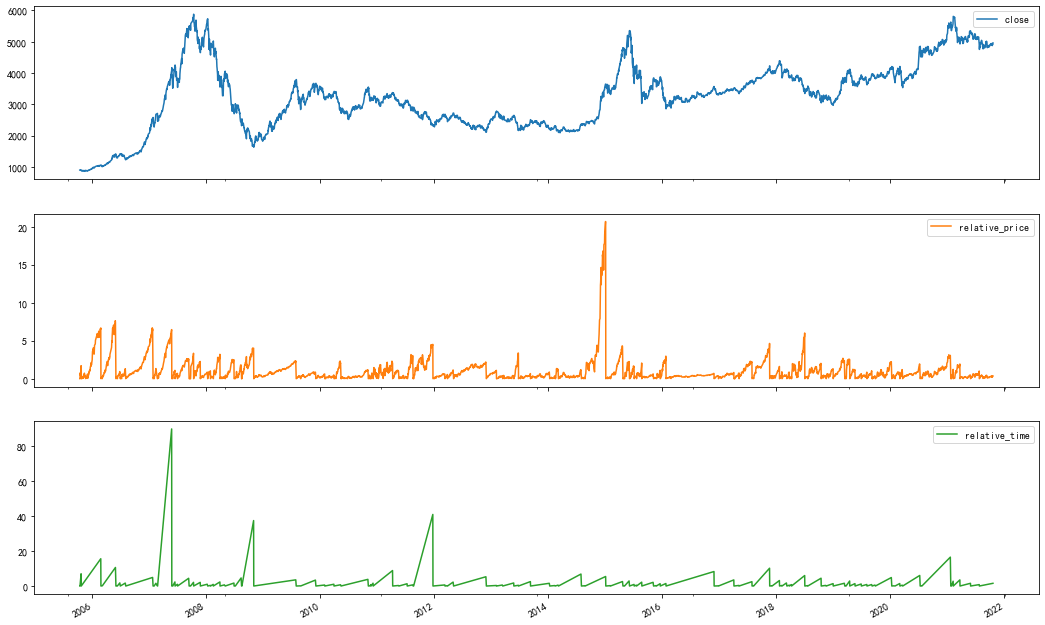

In [31]:
drop_tmp[['close', 'relative_price', 'relative_time']].plot(figsize=(18, 12),
                                                            subplots=True);

2021-09-15的点位效率计算与研报示例一致

In [32]:
test_rv_df.loc['2021-09-15',['close','relative_time','relative_price']]

close             4867.320000
relative_time        0.892857
relative_price       0.196504
Name: 2021-09-15 00:00:00, dtype: float64

# 应用部分

应用部分的思路基本与研报相同,不过这里我直接使用“朴素贝叶斯”实现

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [11]:
X = drop_tmp[['relative_price','relative_time']].values

n_clusters = 3


k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
k_means.fit(X)

k_means_cluster_centers = k_means.cluster_centers_  # 获取聚类核心点

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)  # 计算一个点和一组点之间的最小距离,默认欧式距离

In [12]:
k_mean_cluster_frame:pd.DataFrame = drop_tmp.copy()

k_mean_cluster_frame['label'] = k_means_labels

In [ ]:
import warnings
from numbers import Number
from functools import partial
import math

from seaborn.palettes import color_palette
from seaborn.distributions import _DistributionPlotter
from seaborn._statistics import KDE

#    
def plot_bivariate_density(
    self,
    common_norm,
    fill,
    levels,
    thresh,
    color,
    legend,
    cbar,
    cbar_ax,
    cbar_kws,
    estimate_kws,
    **contour_kws,
):

    contour_kws = contour_kws.copy()

    estimator = KDE(**estimate_kws)

    if not set(self.variables) - {"x", "y"}:
        common_norm = False

    all_data = self.plot_data.dropna()

    # Loop through the subsets and estimate the KDEs
    densities, supports = {}, {}

    for sub_vars, sub_data in self.iter_data("hue", from_comp_data=True):

        # Extract the data points from this sub set and remove nulls
        sub_data = sub_data.dropna()
        observations = sub_data[["x", "y"]]

        # Extract the weights for this subset of observations
        if "weights" in self.variables:
            weights = sub_data["weights"]
        else:
            weights = None

        # Check that KDE will not error out
        variance = observations[["x", "y"]].var()
        if any(math.isclose(x, 0)
                for x in variance) or variance.isna().any():
            msg = "Dataset has 0 variance; skipping density estimate."
            warnings.warn(msg, UserWarning)
            continue

        # Estimate the density of observations at this level
        observations = observations["x"], observations["y"]
        density, support = estimator(*observations, weights=weights)

        # Transform the support grid back to the original scale
        xx, yy = support
        if self._log_scaled("x"):
            xx = np.power(10, xx)
        if self._log_scaled("y"):
            yy = np.power(10, yy)
        support = xx, yy

        # Apply a scaling factor so that the integral over all subsets is 1
        if common_norm:
            density *= len(sub_data) / len(all_data)

        key = tuple(sub_vars.items())
        densities[key] = density
        supports[key] = support

    # Define a grid of iso-proportion levels
    if thresh is None:
        thresh = 0
    if isinstance(levels, Number):
        levels = np.linspace(thresh, 1, levels)
    else:
        if min(levels) < 0 or max(levels) > 1:
            raise ValueError("levels must be in [0, 1]")

    # Transform from iso-proportions to iso-densities
    if common_norm:
        common_levels = self._quantile_to_level(
            list(densities.values()),
            levels,
        )
        draw_levels = {k: common_levels for k in densities}
    else:
        draw_levels = {
            k: self._quantile_to_level(d, levels)
            for k, d in densities.items()
        }

    # Get a default single color from the attribute cycle
    if self.ax is None:
        default_color = "C0" if color is None else color
    else:
        scout, = self.ax.plot([], color=color)
        default_color = scout.get_color()
        scout.remove()

    # Define the coloring of the contours
    if "hue" in self.variables:
        for param in ["cmap", "colors"]:
            if param in contour_kws:
                msg = f"{param} parameter ignored when using hue mapping."
                warnings.warn(msg, UserWarning)
                contour_kws.pop(param)
    else:

        # Work out a default coloring of the contours
        coloring_given = set(contour_kws) & {"cmap", "colors"}
        if fill and not coloring_given:
            cmap = self._cmap_from_color(default_color)
            contour_kws["cmap"] = cmap
        if not fill and not coloring_given:
            contour_kws["colors"] = [default_color]

        # Use our internal colormap lookup
        cmap = contour_kws.pop("cmap", None)
        if isinstance(cmap, str):
            cmap = color_palette(cmap, as_cmap=True)
        if cmap is not None:
            contour_kws["cmap"] = cmap

    # Loop through the subsets again and plot the data
    for sub_vars, _ in self.iter_data("hue"):

        if "hue" in sub_vars:
            color = self._hue_map(sub_vars["hue"])
            if fill:
                contour_kws["cmap"] = self._cmap_from_color(color)
            else:
                contour_kws["colors"] = [color]

        ax = self._get_axes(sub_vars)

        # Choose the function to plot with
        # TODO could add a pcolormesh based option as well
        # Which would look something like element="raster"
        if fill:
            contour_func = ax.contourf
        else:
            contour_func = ax.contour

        key = tuple(sub_vars.items())
        if key not in densities:
            continue
        density = densities[key]
        xx, yy = supports[key]

        label = contour_kws.pop("label", None)

        cset = contour_func(
            xx,
            yy,
            density,
            levels=draw_levels[key],
            **contour_kws,
        )
        
        ax.clabel(cset,inline=True) # 就加了一个这个
        if "hue" not in self.variables:
            cset.collections[0].set_label(label)

        # Add a color bar representing the contour heights
        # Note: this shows iso densities, not iso proportions
        # See more notes in histplot about how this could be improved
        if cbar:
            cbar_kws = {} if cbar_kws is None else cbar_kws
            ax.figure.colorbar(cset, cbar_ax, ax, **cbar_kws)

    # --- Finalize the plot
    ax = self.ax if self.ax is not None else self.facets.axes.flat[0]
    self._add_axis_labels(ax)

    if "hue" in self.variables and legend:

        # TODO if possible, I would like to move the contour
        # intensity information into the legend too and label the
        # iso proportions rather than the raw density values

        artist_kws = {}
        if fill:
            artist = partial(mpl.patches.Patch)
        else:
            artist = partial(mpl.lines.Line2D, [], [])

        ax_obj = self.ax if self.ax is not None else self.facets
        self._add_legend(
            ax_obj,
            artist,
            fill,
            False,
            "layer",
            1,
            artist_kws,
            {},
        )
        
_DistributionPlotter.plot_bivariate_density = plot_bivariate_density

def plot_simple_cluster(k_mean_cluster_frame:pd.DataFrame,k_means_cluster_centers:np.array,x:str,y:str,hue:str):
    '''画聚类图
    
    k_means_cluster_centers:为质心
    '''
    fig, ax = plt.subplots(figsize=(10, 8))

    colors = ['#4EACC5', '#FF9C34', '#4E9A06']

    scatter = sns.scatterplot(data=k_mean_cluster_frame,
                            x=x,
                            y=y,
                            hue=hue,
                            ax=ax,
                            palette=colors)
    
    for i, (r, c) in enumerate(k_means_cluster_centers):

        scatter.plot(r,
                    c,
                    'o',
                    markerfacecolor=colors[i],
                    markeredgecolor='k',
                    markersize=8)

    return scatter

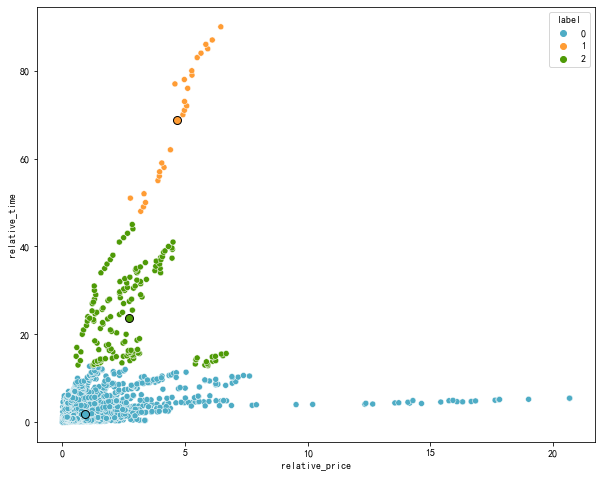

In [15]:
plot_simple_cluster(k_mean_cluster_frame,k_means_cluster_centers,x='relative_price',y='relative_time',hue='label');

概率分布

In [16]:
mel_df = pd.melt(k_mean_cluster_frame,id_vars=['label'],value_vars=list(range(1,25)),var_name=['day'])

In [17]:
slice_df = mel_df.query('label==0').dropna() 
slice_df['day'] = slice_df['day'].astype(int)

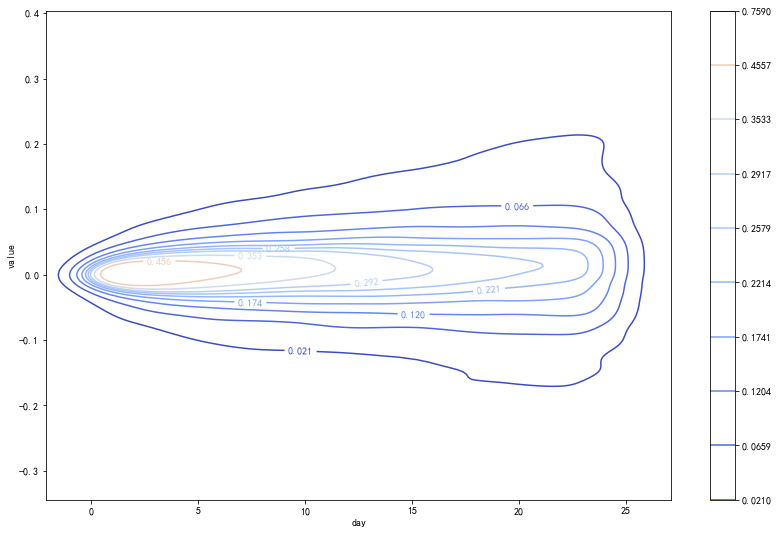

In [18]:
fig,ax = plt.subplots(figsize=(14,9))
sns.kdeplot(data=slice_df, x='day',y='value',cbar=True,cmap="coolwarm");

## 朴素贝叶斯与逻辑回归

In [81]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib # 用于模型导出

In [82]:
train_df = test_rv_df.loc[:'2018-01-01'].dropna()

test_df = test_rv_df.loc['2018-01-01':]

x_test = test_df[['relative_time','relative_price']]

In [84]:
tscv = TimeSeriesSplit(n_splits=5,max_train_size=180)

nb = GaussianNB()

lr = LogisticRegression()

for i,(train_index, test_index) in enumerate(tscv.split(train_df)):

    x_train = train_df.iloc[train_index][['relative_time','relative_price']]
    y_train = train_df.iloc[train_index][1]
    y_sign = np.where(y_train > 0.,1,0)
    lr.fit(x_train,y_sign)
    nb.fit(x_train,y_sign)

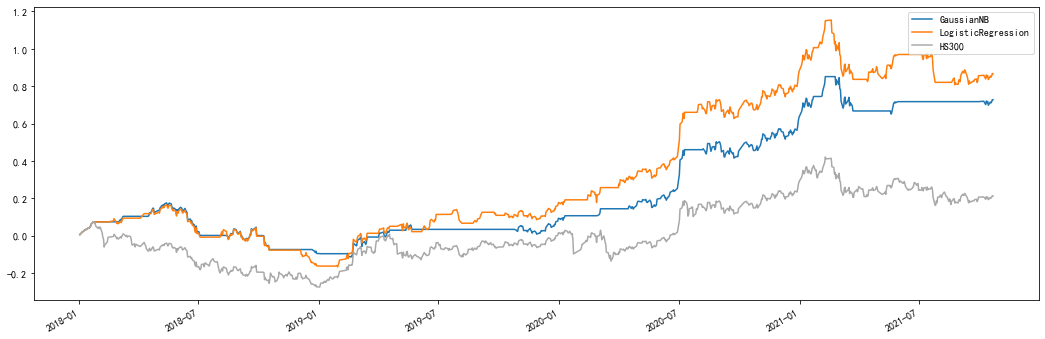

In [86]:
df = pd.DataFrame()
next_ret = test_rv_df['close'].pct_change().shift(-1)

df['GaussianNB'] = next_ret.loc[test_df.index] * nb.predict(x_test)
df['LogisticRegression'] = next_ret.loc[test_df.index] * lr.predict(x_test)
ep.cum_returns(df).plot(figsize=(18,6))

ep.cum_returns(next_ret.loc[x_test.index]).plot(color='darkgray',label='HS300')
plt.legend();